# running pipeline for basic linear regression and neural nets
Based on the pipeline that was developed and run on 10/27

This includes the preprocessing pipeline, imputation pipeline, and the predictions

Basic neural networks and linear models from sklearn were used

Run below block to start

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from utils import *
from sklearn.metrics import mean_squared_error

## only run if loading data

In [2]:
#comment out this below block and run following cell if you don't want to load the data
dataloder = LoadData(impute='KNN',load = True)
m = dataloder.m
p = dataloder.p
p_cols = dataloder.p_cols
p_dict = dataloder.p_dict
cv = CV(m,p,p_cols,p_dict)

## only run if not loading data

In [2]:
dataloder = LoadData(impute='KNN', load=False)
m = dataloder.m
p = dataloder.p
p_cols = dataloder.p_cols
p_dict = dataloder.p_dict
cv = CV(m,p,p_cols,p_dict)
#fold_list = cv.folds(n = 5, random_state = 42)

In [3]:
#will save file so easy to load in the future, no need to rerun
dataloder.savefile('m_knn','p_knn','p_cols')
dataloder.m = None
dataloder.p = None
dataloder.p_cols = None


In [4]:
dataloder.loadfile('m_knn.npy', 'p_knn.npy', 'p_cols.npy')
print(dataloder.m.shape)
print(dataloder.p.shape)
print(dataloder.p_cols.shape)
#perfect!

(25818, 251)
(25818, 1039)
(1039,)


# running models

In [3]:
#now we use the inbuilt trian loop instead of defining my own
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.1, random_state=420)
predicts = cv.train_loop(model)


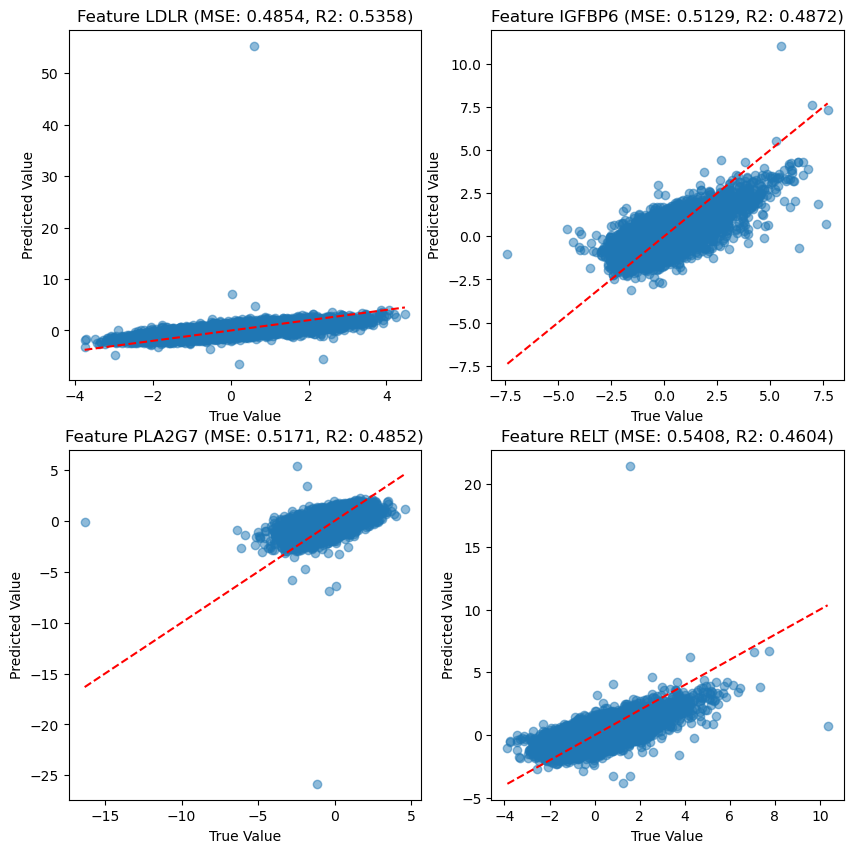

In [6]:
from sklearn.metrics import mean_squared_error
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[:4])

Text(0.5, 0.98, 'Ridge Regression')

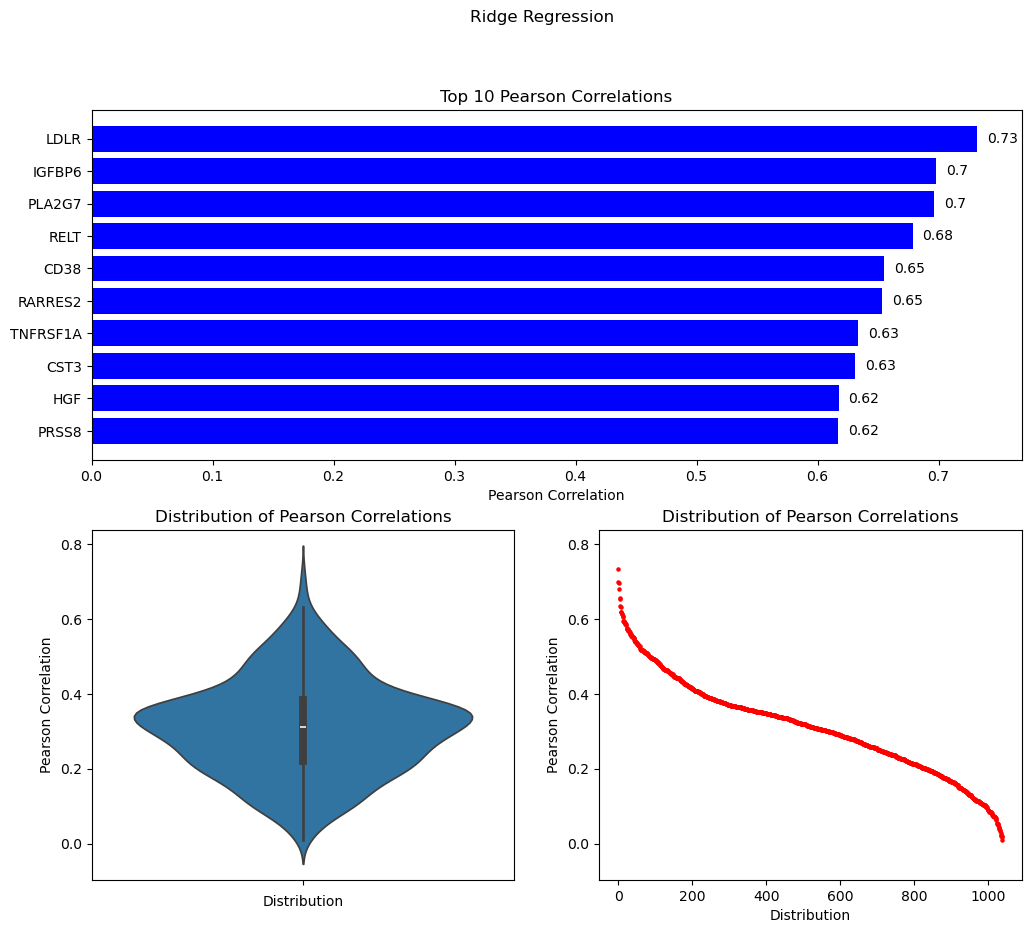

In [8]:
fig,axs = cv.pred_summary_plot()
#change the suptitle
fig.suptitle('Ridge Regression')

In [17]:
#now lasso regression
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1, random_state=420)
predicts = cv.train_loop(model)

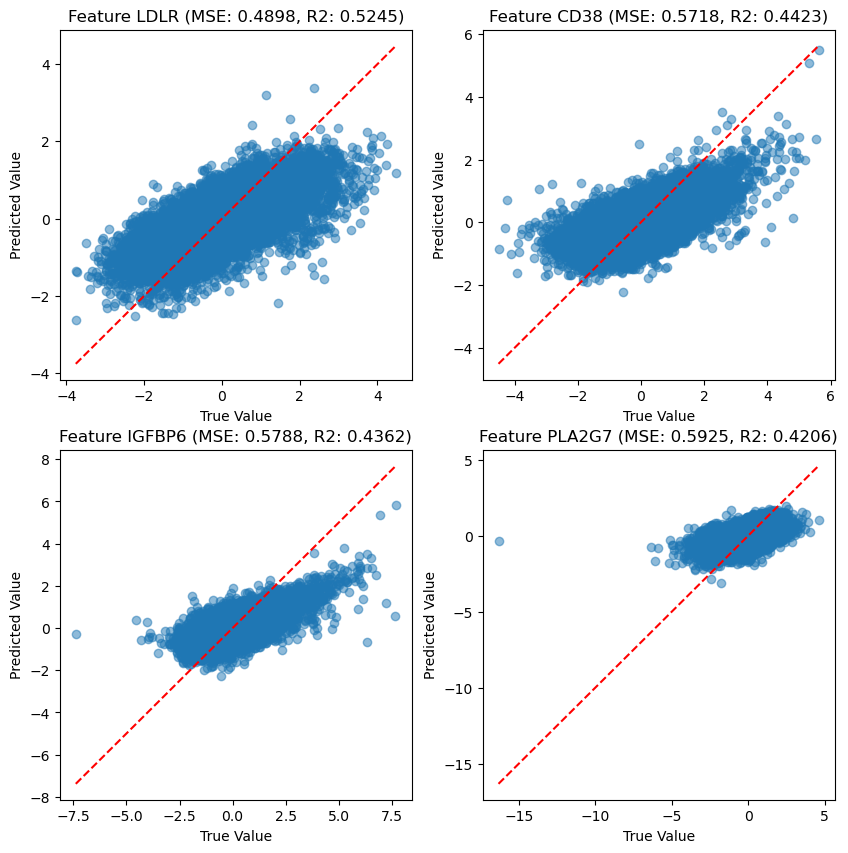

In [18]:
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[:4])

Text(0.5, 0.98, 'Lasso Regression')

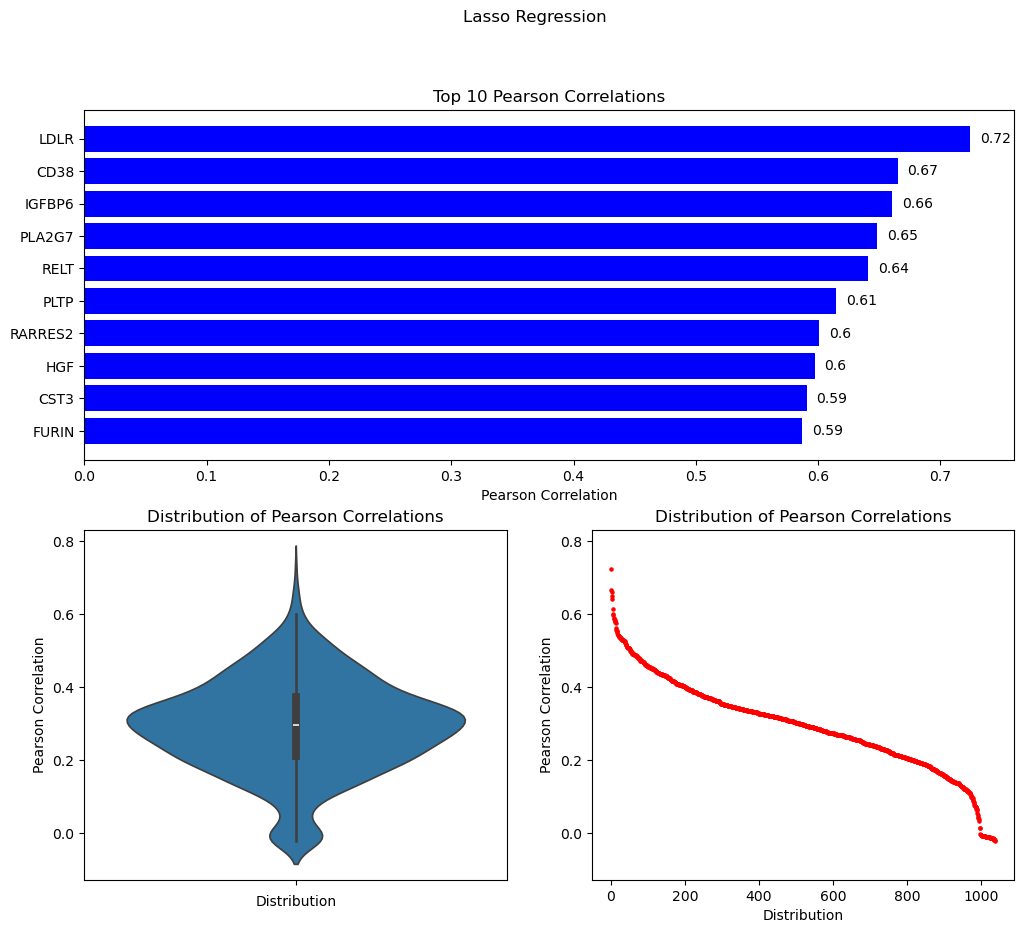

In [19]:
fig,axs = cv.pred_summary_plot()
fig.suptitle('Lasso Regression')

In [9]:
#now Linear regression

from sklearn.linear_model import LinearRegression
model = LinearRegression()
predicts = cv.train_loop(model) #simply utilizing the same folds, but it writes it over I'm quite sure!

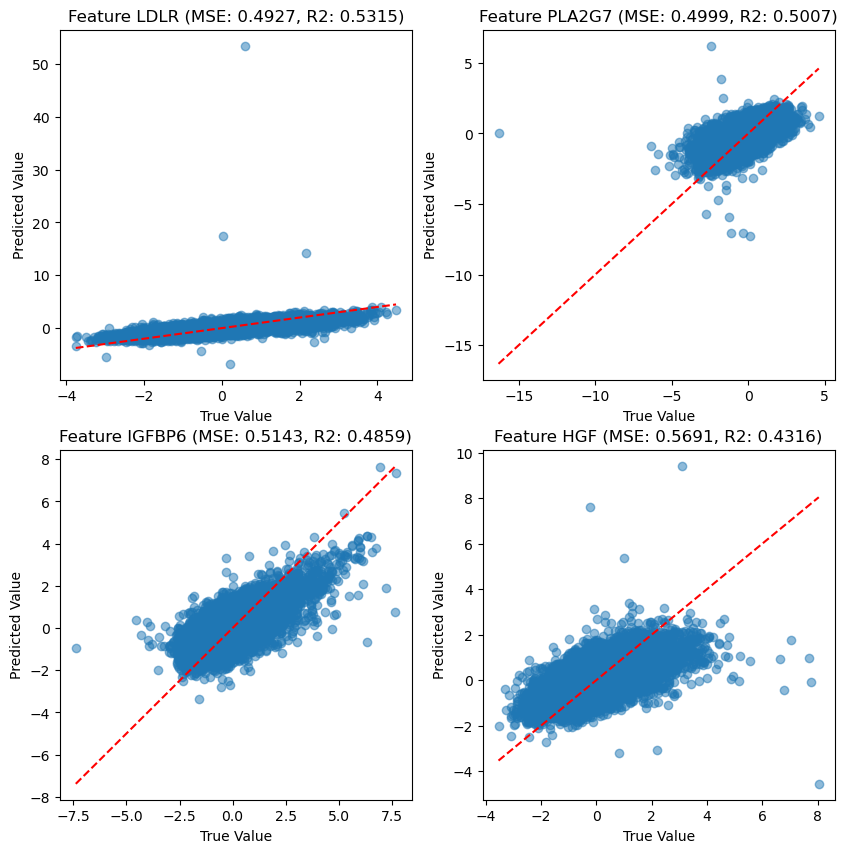

In [10]:
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[:4])

Text(0.5, 0.98, 'Linear Regression')

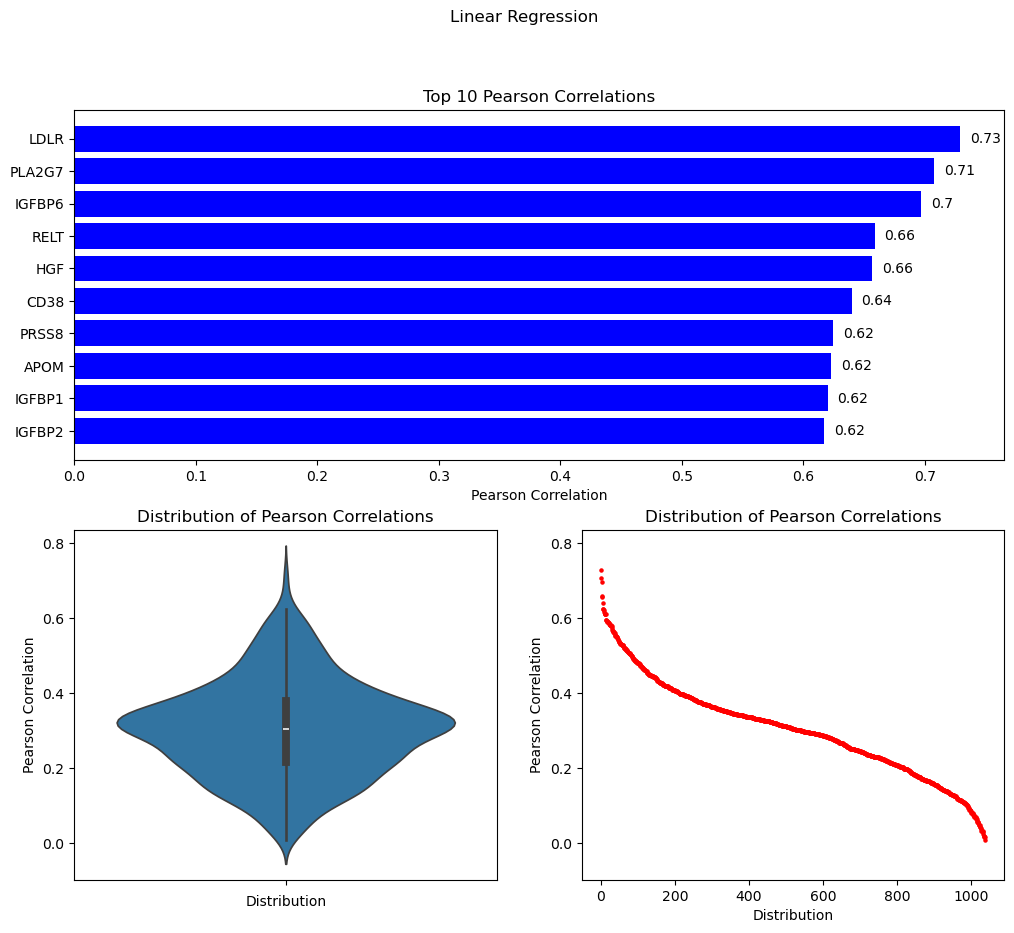

In [12]:
fig,axs = cv.pred_summary_plot()
fig.suptitle('Linear Regression')

In [13]:
#now let's do elastic net
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=420)
predicts = cv.train_loop(model) #simply utilizing the same folds, but it writes it over I'm quite sure!

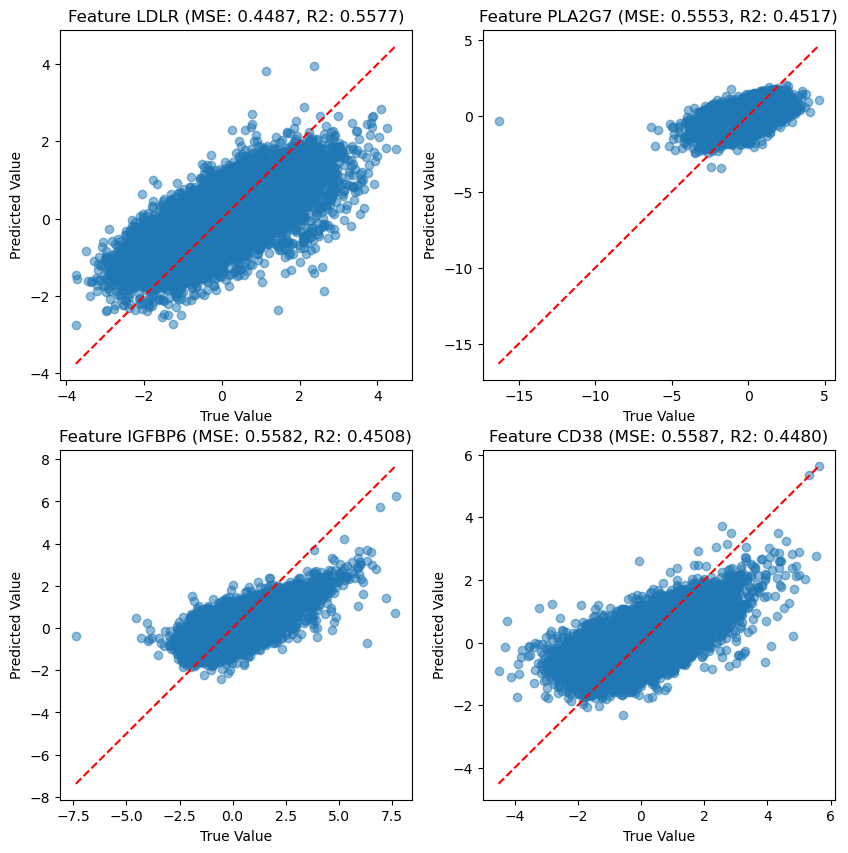

In [14]:
fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[:4])

Text(0.5, 0.98, 'Elastic Net')

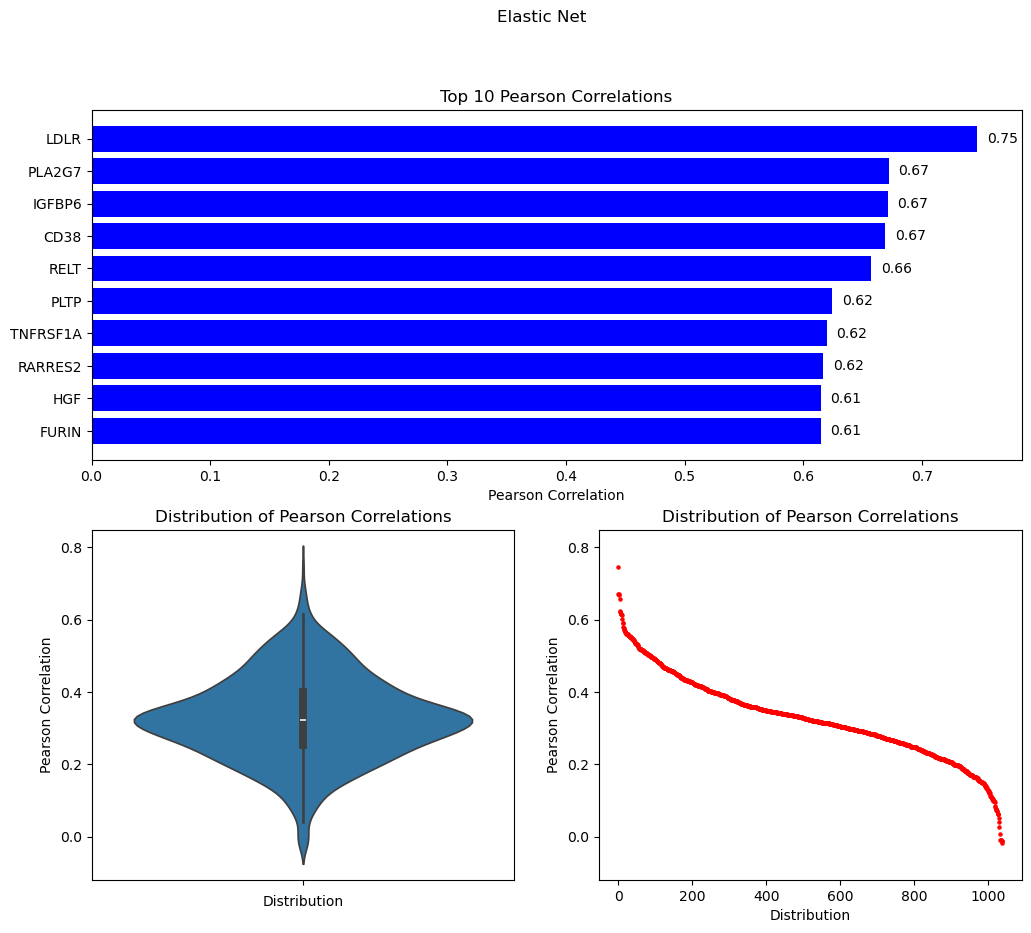

In [16]:
fig,axs = cv.pred_summary_plot()
fig.suptitle('Elastic Net')

# nonlinear models

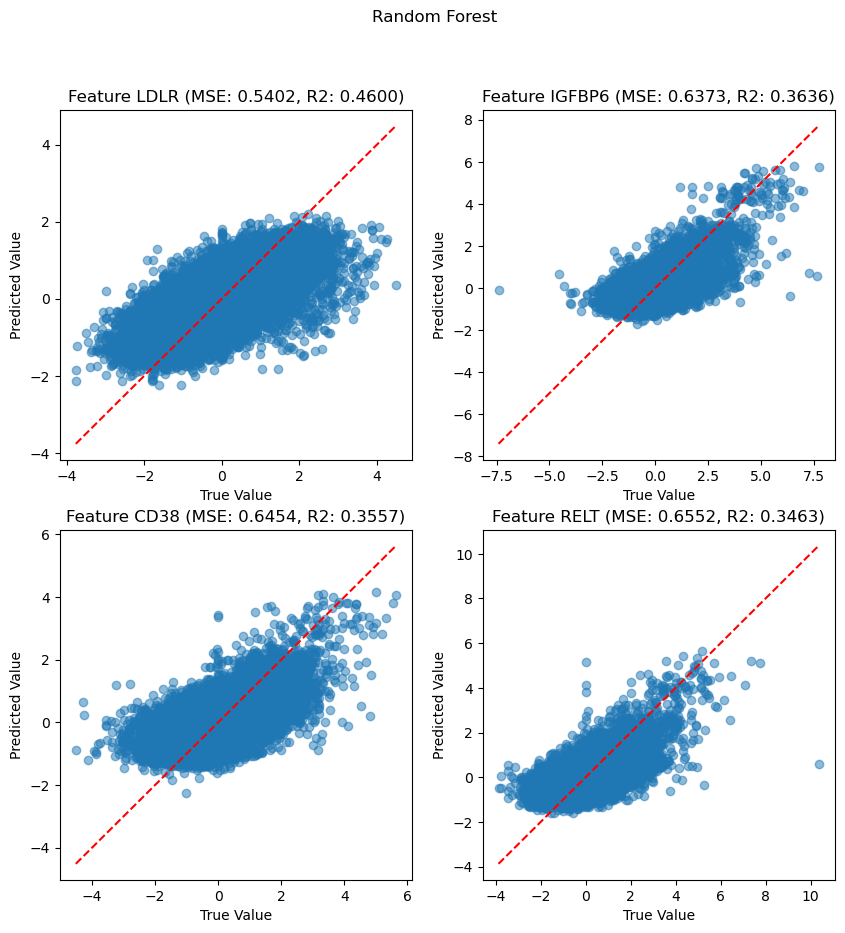

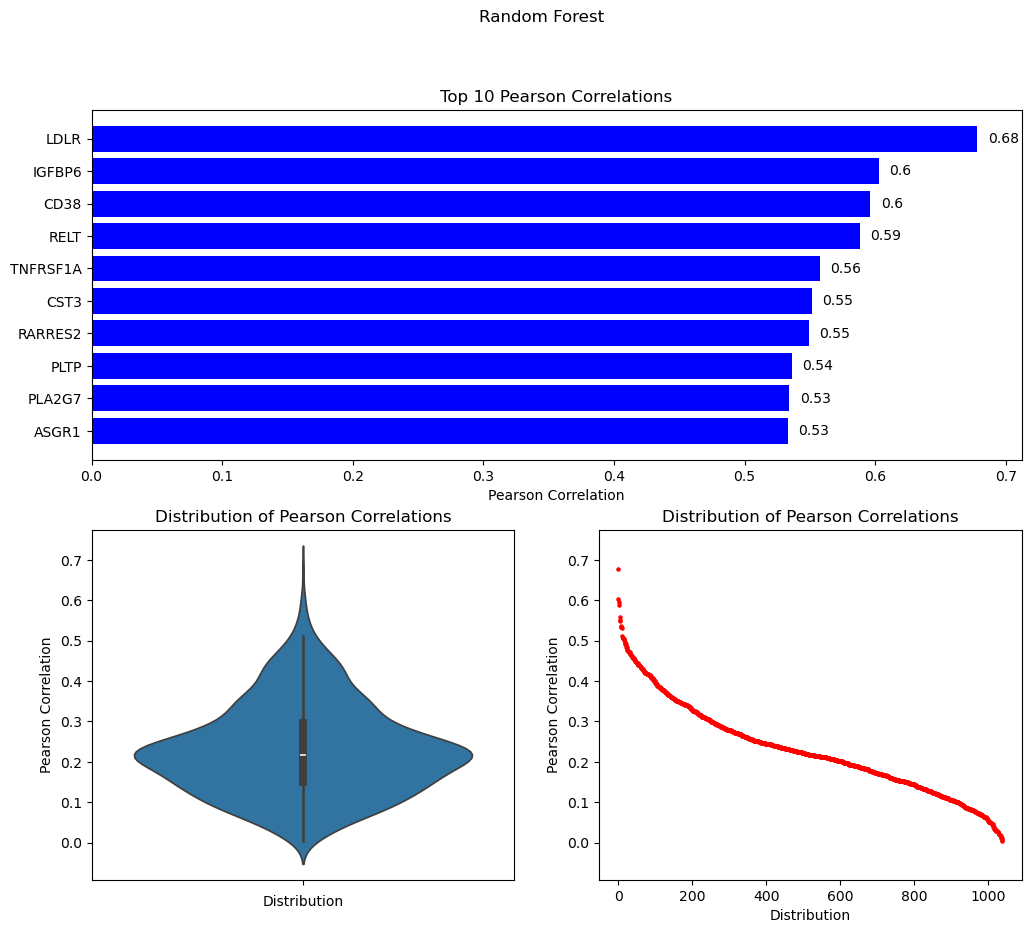

In [5]:
#still going to do sklearn, but like random forest and svm and stuff

# from sklearn.ensemble import RandomForestRegressor
# model = RandomForestRegressor(n_estimators=10, random_state=420)
# predicts = cv.train_loop(model) #simply utilizing the same folds, but it writes it over I'm quite sure!

cv.load_file('RF.npy')

fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('Random Forest')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('Random Forest')
plt.show(fig)


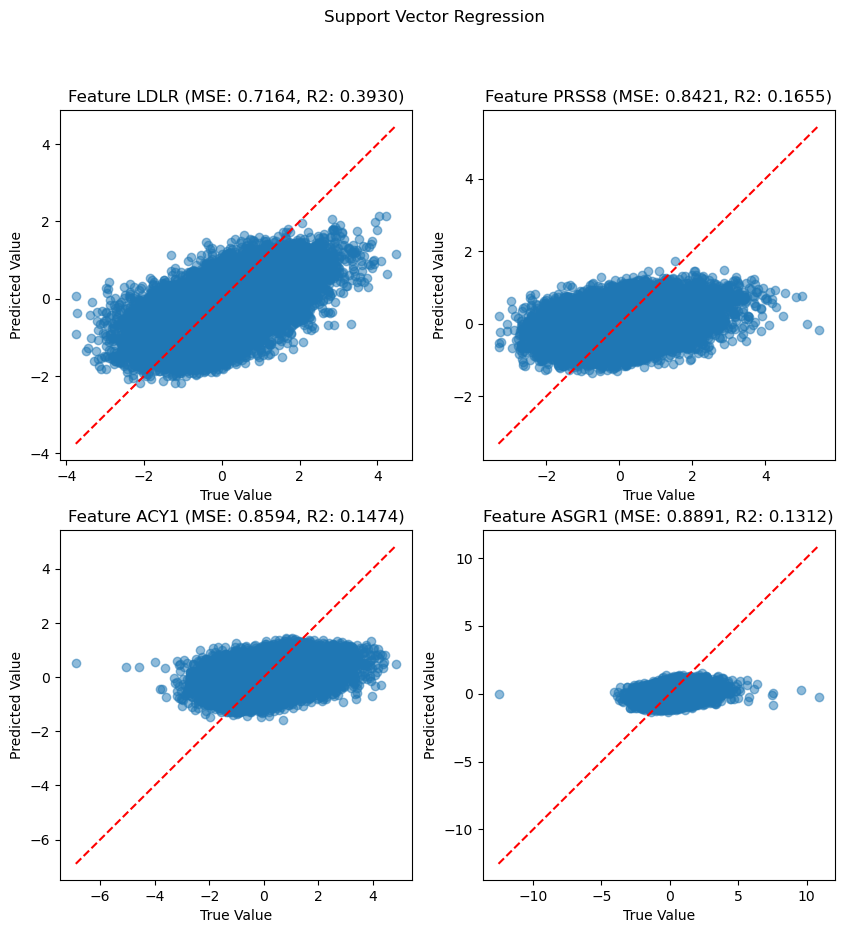

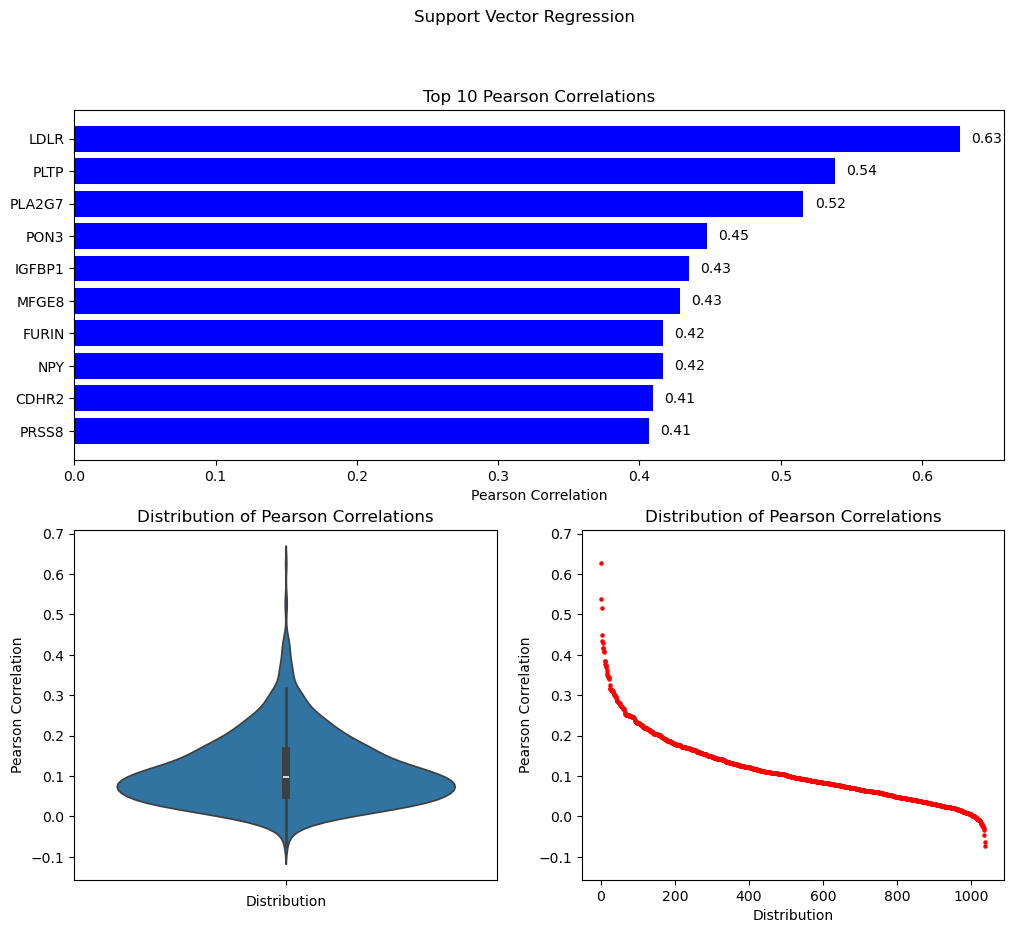

In [3]:
#now SVM
# from sklearn.svm import SVR
# svr = SVR(kernel='rbf')
# from sklearn.multioutput import MultiOutputRegressor
# model = MultiOutputRegressor(svr)
# predicts = cv.train_loop(model) #simply utilizing the same folds, but it writes it over I'm quite sure!

cv.load_file('SVR.npy')

fig,axs = cv.idx_plot(feature_list = np.argsort(mean_squared_error(p, cv.predict, multioutput='raw_values'))[:4])
fig.suptitle('Support Vector Regression')
plt.show(fig)

fig,axs = cv.pred_summary_plot()
fig.suptitle('Support Vector Regression')
plt.show(fig)

#not enough time to converge, limited the amount of iterations

In [ ]:
#now let's do a nn, we have the folds and everything, so just manually save them out, can add this to the pipeline as well

import torch
import torch.nn as nn
import pytorch_lightning as pl

class Net(pl.LightningModule):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(251, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1461)
        self.losses = []

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on final layer as it's a regression task
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.losses.append(loss)
        return {'test_loss': loss}

    def on_test_end(self):
        avg_loss = torch.stack([x for x in self.losses]).mean()
        print(f'avg_test_loss: {avg_loss}')
        #self.log('avg_test_loss', avg_loss)

p_tensor = torch.Tensor(p)
m_tensor = torch.Tensor(m)

#now use the folds to loop through and train the model

model = Net()

trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)  # Set the number of epochs and gpus
#print(torch.cuda.memory_allocated(device))
